In [1]:
import pandas as pd
import numpy as np
import gensim
import gensim.downloader as gensim_api
from bs4 import BeautifulSoup
import spacy
import xml.etree.ElementTree as ET 
import pickle

## Preparation

- load all papers
- download a pretrained model for vector-representation based KMeans
- extract index terms
- normalize/lemmatize text.

### Load all papers

In [6]:
class XMLLoader:
    def __init__(self):
        self.xmls = []
        self.items = []
        
    def add_ans(self, i, affs, iterms):
        self.items[i]['affiliations'] = affs
        self.items[i]['keywords'] = iterms
        
    def dump(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self.items, f)
                
    def read_xml(self, year, xml_path):
        """
        return the BeautifulSoup parsed result of a given xml file
        """
        xml_path = xml_path.strip()
        with open(xml_path, 'r') as f:
            content = f.read()
            bs_content = BeautifulSoup(content, 'lxml')
            
            for item in bs_content.find_all('item'):
                title = item.title.get_text()
                abstract = item.abstract.get_text()
                author = item.author.get_text().split(',')
                url = item.url.get_text()
                ans = {'conf': 'INTERSPEECH', 
                   'year': year, 
                   'title': title, 
                   'abstract': abstract, 
                   'authors': author, 
                   'affiliations': [], 
                   'keywords': [], 
                   'url': url}
                self.items.append(ans)

In [4]:
with open('final.pkl', 'rb') as f:
    xml_loader = pickle.load(f)

### Download a pretrained model

In [5]:
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


### Extract Index Terms

In [8]:
# extract index terms
index_terms = []
original_terms = []
for item in xml_loader.items:
    for kw in item['keywords']:
        index_terms.append(kw.split())
        original_terms.append(kw)

### Lemmatize Index Terms

In [9]:
# normalize/lemmatize index terms
from tqdm import tqdm
nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatization(words, original_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    ret = []
    index2lemma = {}
    for idx, sent in enumerate(tqdm(words)):
        doc = nlp(" ".join(sent))
        ret.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
        old_word = original_words[idx]
        new_word = ret[-1]
        index2lemma[old_word] = new_word
    return ret, index2lemma

# Only use open class data
lemmas, index2lemma = lemmatization(index_terms, original_terms)
data_uniq = list(set(lemmas))

100%|██████████| 38221/38221 [01:15<00:00, 507.94it/s]


## Vector-represation Based KMeans
- embed index terms
- run KMeans with sklearn package
- present cluster results

### Embed Index Terms

In [10]:
# embed index terms
def embed_index_term(terms, model):
    fail = []
    success = []
    label = []
    for keys in tqdm(terms):
        keys = keys.strip().split()
        status, vec = embed_one(keys, model)
        if status:
            success.append(vec)
            label.append(' '.join(keys))
        else:
            fail.append(vec)
    return fail, success, label

def embed_one(keys, model):
    all_in = True
    for key in keys:
        if key not in model.vocab:
            all_in = False
            break
    
    if not all_in:
        return False, keys
    ret = np.zeros((50), dtype=float)
    for key in keys:
        ret += np.array(model[key], dtype=float)
    return True, ret
fail, success, label = embed_index_term(data_uniq, model)

100%|██████████| 10038/10038 [00:00<00:00, 48773.97it/s]


### Run KMeans

In [12]:
# cluster 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=150, init='k-means++')
data_mat = np.array(success)
kmeans.fit(data_mat)

KMeans(n_clusters=150)

### Show Results

In [13]:
# show cluster results
cluster = [[] for i in range(150)]
for idx, c in enumerate(kmeans.labels_):
    cluster[c].append(idx)

In [15]:
show_id = 3
for x in cluster[show_id]:
    print(label[x])

dialogue learning
feature normalization
dialog policy
entity normalization
dialogue structure
spontaneous dialog
joint decoding
sign synthesis
mutual intelligibility
meeting summarization
problematic dialogue
phase wrapping
qualitative agreement
dialog act
nuclear norm regularization
spatial resolution
dialog separation
normalize flow
normalization
dialogue flow
pitch normalization
dialog history
dialog strategy
dialogue act
bilateral implant
batch normalization
score normalization
dialogue behavior
task orient dialog
unsupervised normalization
problematic dialog
dialogue sequence labeling
breakdown dialog
listen orient dialogue
gesture coordination
cooperative principle
dialogue agent
dialogue ranking
dialogue
joint diagonalization
normalization flow
dialogue classification
speech normalization
task orient dialogue
audiovisual integration
extractive meeting summarization
score normalisation
dialogue segmentation
length normalization
power normalization
dialogue design
dialog structure

<BarContainer object of 100 artists>

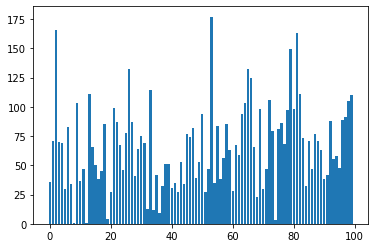

In [16]:
# cluster size distribution
import matplotlib.pyplot as plt 
plots = []
for i in range(100):
    plots.append(len(cluster[i]))
fig, ax = plt.subplots()
ax.bar(list(range(len(plots))), plots)

## Weighted Levenshtein Distance based KMeans
- prepare WER function. Given the ref and hyp string, WER function returns the number of substitution, insertion, and deletion needed to transform ref to hyp. 
- If there're not many index terms, then prepare a distance matrix to accelerate the later clustering process; Otherwise, please compute the distance on the fly.
- Run kmeans
    - The cluster center is the index term with the least distance to the other cluster members.
    - Substitution weight: 1.0, Insertion weight: 0.8, Deleteion weight: 1.0
    - We prefer the insertion error than the other twos, because a ref index term with more insertion errors than the other two types of errors, can cover a broader topic. 
    - e.g.: ref=[`noise`, `noise classification`], hyp=[`noise cancelling`], although both ref index terms have 1 WER value, `noise`(with 1 insertion error) is a better center than `noise classification`(with 1 substitution error), because it covers `noise cancelling`, while `noise classification` falls into a different topic.
- Mapping: store results to `cluster.pkl`, which could map index term to a cluster represative word


### Prepare WER function

In [ ]:
# copy from https://holianh.github.io/portfolio/Cach-tinh-WER/#:~:text=WER-,Word%20Error%20Rate%20(WER)%20and%20Word,Recognition%20Rate%20(WRR)%20with%20Python&text=WER%20has%20been%20developed%20and,real%20text%20%2D%20called%20the%20reference.
def my_wer(ref, hyp ,debug=False):
    r = ref.split()
    h = hyp.split()
    #costs will holds the costs, like in the Levenshtein distance algorithm
    costs = [[0 for inner in range(len(h)+1)] for outer in range(len(r)+1)]
    # backtrace will hold the operations we've done.
    # so we could later backtrace, like the WER algorithm requires us to.
    backtrace = [[0 for inner in range(len(h)+1)] for outer in range(len(r)+1)]

    OP_OK = 0
    OP_SUB = 1
    OP_INS = 2
    OP_DEL = 3

    DEL_PENALTY=1 # Tact
    INS_PENALTY=1 # Tact
    SUB_PENALTY=1 # Tact
    # First column represents the case where we achieve zero
    # hypothesis words by deleting all reference words.
    for i in range(1, len(r)+1):
        costs[i][0] = DEL_PENALTY*i
        backtrace[i][0] = OP_DEL

    # First row represents the case where we achieve the hypothesis
    # by inserting all hypothesis words into a zero-length reference.
    for j in range(1, len(h) + 1):
        costs[0][j] = INS_PENALTY * j
        backtrace[0][j] = OP_INS

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                costs[i][j] = costs[i-1][j-1]
                backtrace[i][j] = OP_OK
            else:
                substitutionCost = costs[i-1][j-1] + SUB_PENALTY # penalty is always 1
                insertionCost    = costs[i][j-1] + INS_PENALTY   # penalty is always 1
                deletionCost     = costs[i-1][j] + DEL_PENALTY   # penalty is always 1

                costs[i][j] = min(substitutionCost, insertionCost, deletionCost)
                if costs[i][j] == substitutionCost:
                    backtrace[i][j] = OP_SUB
                elif costs[i][j] == insertionCost:
                    backtrace[i][j] = OP_INS
                else:
                    backtrace[i][j] = OP_DEL

    # back trace though the best route:
    i = len(r)
    j = len(h)
    numSub = 0
    numDel = 0
    numIns = 0
    numCor = 0
    if debug:
        print("OP\tREF\tHYP")
        lines = []
    while i > 0 or j > 0:
        if backtrace[i][j] == OP_OK:
            numCor += 1
            i-=1
            j-=1
            if debug:
                lines.append("OK\t" + r[i]+"\t"+h[j])
        elif backtrace[i][j] == OP_SUB:
            numSub +=1
            i-=1
            j-=1
            if debug:
                lines.append("SUB\t" + r[i]+"\t"+h[j])
        elif backtrace[i][j] == OP_INS:
            numIns += 1
            j-=1
            if debug:
                lines.append("INS\t" + "****" + "\t" + h[j])
        elif backtrace[i][j] == OP_DEL:
            numDel += 1
            i-=1
            if debug:
                lines.append("DEL\t" + r[i]+"\t"+"****")
    if debug:
        lines = reversed(lines)
        for line in lines:
            print(line)
        print("Ncor " + str(numCor))
        print("Nsub " + str(numSub))
        print("Ndel " + str(numDel))
        print("Nins " + str(numIns))
    return numSub, numIns, numDel

In [ ]:
print(my_wer("hello world", "hello hi world"))

(0, 1, 0)


### Prepare distance matrix

In [ ]:
# prepare distance matrix
nword = len(label)
distance_mat = np.zeros((nword, nword, 3), dtype=int)
for rid, ref in tqdm(enumerate(label)):
    for hid, hyp in enumerate(label):
        s, i, d = my_wer(ref, hyp)
        distance_mat[rid, hid, 0] = s
        distance_mat[rid, hid, 1] = i
        distance_mat[rid, hid, 2] = d

# np.save('dist_mat', distant_mat)

# weighted distance
# sum_dist = distance_mat * np.array(0.9, 0.8, 1.0], dtype=float)
sum_dist = distance_mat * np.array([1.0, 0.8, 1.0], dtype=float)
sum_dist = np.sum(sum_dist, axis=2)
print(sum_dist.shape)

9224it [26:21,  5.83it/s]


### Run KMeans

In [22]:
# run kmeans
import random
class LevenshteinKMeans:
    def __init__(self, seeds, label, dist_mat, niter):
        """ KMeans, with Levenshtein distance as the 
        distance metric
        """
        self.label = label
        self.init_seeds = seeds
        self.dist_mat = dist_mat 
        self.niter = niter
        self.nword = len(label)
        self.ncluster = len(seeds)
        self.clusters = None
        self.cluster_ids = None

    def adapt(self):
        self.cluster_ids = self.init_seeds
        for idx in tqdm(range(self.niter)):
            self.clusters = self.assign_cluster(self.cluster_ids)
            self.cluster_ids = self.recomputer_centers(self.clusters)

    def assign_cluster(self, cluster_ids):
        clusters = [[] for i in range(self.ncluster)]
        for i in range(self.nword):
            dist_to_seeds = self.dist_mat[i][cluster_ids]
            min_id = self.get_min_id(dist_to_seeds)
            clusters[min_id].append(i)
        return clusters
    
    def get_min_id(self, dist_to_seeds):
        """ Return the id of the most similar word, if there're multiple words
        having the same edit distance to the ref, randomly return an id of them.
        """
        min_val = dist_to_seeds.min()
        candidates = (dist_to_seeds==min_val).nonzero()[0]
        idx = random.randint(0, len(candidates)-1)
        return candidates[idx]

    def recomputer_centers(self, clusters):
        centers = []
        uniq_set = set()
        uniq_set.add(0)
        for cluster in clusters:
            centers.append(self.find_center(cluster, uniq_set))
        return centers

    def find_center(self, cluster, uniq_set):
        scores = []
        for rid, ref in enumerate(cluster):
            ref_to_others = self.dist_mat[ref][cluster]
            scores.append([ref_to_others.sum(), ref])
        scores.sort()
        best_id = scores[0][1]
        for _, id in scores:
            if id in uniq_set:
                continue
            uniq_set.add(id)
            best_id = id
            break
        return best_id

rand_seeds = random.sample(range(1, len(label)), 150)
lkmeans = LevenshteinKMeans(rand_seeds, label, sum_dist, 40)
lkmeans.adapt()

100%|██████████| 40/40 [00:12<00:00,  3.33it/s]


In [32]:
# show results
cluster_word = []
for idx, kw in enumerate(lkmeans.cluster_ids):
    cluster_word.append([lkmeans.label[kw], idx])
cluster_word.sort()
kw, kid = cluster_word[2]
print('center:', kw)
for member in lkmeans.clusters[kid]:
    print(lkmeans.label[member])

center: adaptation
dynamic adaptation
adaptation know accent
escalation
adaptive decomposition
computing
regional
affinity
figure
induction
robustness outlier
adaptation algorithm
basis adaptation
diversity
multilingual adaptation
fuse hmm adaptation
channel adaptation
phonetic adaptation
room acoustic adaptation
refined adaptation
feature adaptation
threshold
adaptation regularization
actor
software library
cut
permutation free scheme
native
phrase boundary
channel
supervised adaptation
category adaptation
gain adaptation
accent british isle
loanword adaptation
adaptation
visual feedback
adversarial example
news summarization
intra
fold vibration
self adaptation
singer adaptation
scale adaptation
lexical adaptation
germination
normalization


### Mapping: map index term to cluster representative or itself

We only execute the mapper when there are common words between the index term and the cluster representative, otherwise the index term will be mapped to itself.

In [33]:
class BuildMapper:
    def __init__(self, clusters, cluster_ids, index2lemma, label):
        self.clusters = clusters
        self.label = label
        self.cluster_ids = cluster_ids
        self.index2cluster = {}
        self.index2lemma = index2lemma
    
    def generate_mapping_dict(self):
        """ Prepare a dict which can map an index term 
        to the cluster representative word
        """
        lemma2cluster = {}
        for idx in range(len(self.cluster_ids)):
            center = self.label[self.cluster_ids[idx]]
            center_dict = set(center.split(' '))
            for index in self.clusters[idx]:
                index_term = self.label[index]
                hits = self.__cal_hit(center_dict, index_term) 
                if hits > 0:
                    lemma2cluster[index_term] = center
        
        for index in self.index2lemma:
            lemma = self.index2lemma[index]
            if lemma in lemma2cluster:
                cluster = lemma2cluster[lemma]
                self.index2cluster[index] = cluster 
            else:
                self.index2cluster[index] = lemma
    
    def __cal_hit(self, center_dict, index_term) -> int:
        """ Return the number of hits. If there are k words both
        exist in the center_dict and the index term, then
        there are k hits in total.
        """
        
        cnt = 0
        for w in index_term.split(' '):
            w = w.strip()
            if w in center_dict:
                cnt += 1
        
        return cnt
        
pc = BuildMapper(lkmeans.clusters, lkmeans.cluster_ids, index2lemma, label) 
pc.generate_mapping_dict()
new_keywords = []
for k in pc.index2cluster:
    new_keywords.append(pc.index2cluster[k])
    
with open('cluster.dict', 'wb') as f:
    pickle.dump(pc.index2cluster, f)